<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_GRU/CNN_GRU_Nvidia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 1.51 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 18:52:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Nvidia'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 14.7 MB/s 
     |████████████████████████████████| 133 kB 62.5 MB/s 
     |████████████████████████████████| 170 kB 60.2 MB/s 
     |████████████████████████████████| 97 kB 7.6 MB/s 
     |████████████████████████████████| 138 kB 63.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(GRU(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 5jyb2ze9
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_GRU/sweeps/5jyb2ze9


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: cimg6pgl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
16/16 [==============================] - 37s 69ms/step - loss: 0.0848 - mean_squared_error: 0.0848 - mean_absolute_error: 0.1854 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1486
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1153 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1173
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0342 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1139
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0219 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1179
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_err

epoch,11
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.02016
val_loss,0.02442
val_mean_squared_error,0.02442
val_mean_absolute_error,0.11289
_runtime,46
_timestamp,1626893605
_step,11
best_val_loss,0.02122


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▁▁▁▁▁▁▁▁▁
val_loss,█▁▄▅▅▄▄▄▃▃▄▄
val_mean_squared_error,█▁▄▅▅▄▄▄▃▃▄▄
val_mean_absolute_error,█▂▁▂▂▁▁▁▁▁▁▁
_runtime,▁▁▅▅▅▅▅▅▅▅▅█
_timestamp,▁▁▅▅▅▅▅▅▅▅▅█
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: qow5rqsh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 3s 53ms/step - loss: 1.4915 - mean_squared_error: 1.4915 - mean_absolute_error: 0.4692 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1254
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0274 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1110
Epoch 3/200
16/16 [==============================] - 0s 5ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - mean_absolute_error: 0.0958 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1510
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0605 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1147
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_erro

epoch,79
loss,0.00156
mean_squared_error,0.00156
mean_absolute_error,0.02235
val_loss,0.01535
val_mean_squared_error,0.01535
val_mean_absolute_error,0.09546
_runtime,16
_timestamp,1626893631
_step,79
best_val_loss,0.00957


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▄▂▂▂█▄▆▂▂▂▂▂▁▂▇▂▂▂▁▂▅▂▁▁▃▁▂▂▂▁▁▁▁▁▂▁▃▄▂
val_mean_squared_error,▃▄▂▂▂█▄▆▂▂▂▂▂▁▂▇▂▂▂▁▂▅▂▁▁▃▁▂▂▂▁▁▁▁▁▂▁▃▄▂
val_mean_absolute_error,▃▄▂▂▂█▄▆▃▂▂▂▃▂▂▇▂▂▂▁▂▆▃▁▁▄▁▃▃▂▁▁▁▂▁▃▁▃▆▂
_runtime,▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5ip6s46v with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 75ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1219 - val_loss: 0.0347 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1381
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0335 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1185
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0249 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1106
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0225 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1116
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_error: 0.

epoch,49
loss,0.00093
mean_squared_error,0.00093
mean_absolute_error,0.01766
val_loss,0.01472
val_mean_squared_error,0.01472
val_mean_absolute_error,0.08696
_runtime,14
_timestamp,1626893655
_step,49
best_val_loss,0.01422


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▄▄▃▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▄▄▄▃▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: sxk0gddk with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 56ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_error: 0.0910 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1195
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0279 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1176
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0287 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1060
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0247 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1020
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 9.9377e-04 - mean_squared_error

epoch,49
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.01602
val_loss,0.00754
val_mean_squared_error,0.00754
val_mean_absolute_error,0.06358
_runtime,14
_timestamp,1626893683
_step,49
best_val_loss,0.00462


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂
val_loss,█▆▆▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▃▂
val_mean_squared_error,█▆▆▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▃▂
val_mean_absolute_error,██▇▆▅▅▄▄▃▃▃▃▂▂▂▂▃▃▄▂▂▂▃▁▁▁▁▁▂▁▃▂▂▂▁▁▁▂▄▃
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lre44oiz with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 108ms/step - loss: 0.1040 - mean_squared_error: 0.1040 - mean_absolute_error: 0.2014 - val_loss: 0.2860 - val_mean_squared_error: 0.2860 - val_mean_absolute_error: 0.4937
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0752 - mean_squared_error: 0.0752 - mean_absolute_error: 0.1673 - val_loss: 0.1814 - val_mean_squared_error: 0.1814 - val_mean_absolute_error: 0.3920
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0496 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1474 - val_loss: 0.1043 - val_mean_squared_error: 0.1043 - val_mean_absolute_error: 0.2977
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1305 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.2293
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0214 - mean_squared_error: 0.0214

epoch,25
loss,0.00124
mean_squared_error,0.00124
mean_absolute_error,0.02423
val_loss,0.02387
val_mean_squared_error,0.02387
val_mean_absolute_error,0.11301
_runtime,9
_timestamp,1626893703
_step,25
best_val_loss,0.02202


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅██████████
_timestamp,▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅██████████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: yi3x43u2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 3s 54ms/step - loss: 0.0464 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1178 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1431
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0429 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1366
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0226 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1229
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0218 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1092
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_erro

epoch,68
loss,0.00047
mean_squared_error,0.00047
mean_absolute_error,0.0121
val_loss,0.0075
val_mean_squared_error,0.0075
val_mean_absolute_error,0.06093
_runtime,15
_timestamp,1626893730
_step,68
best_val_loss,0.00658


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▅▅▅▅▄▄▄▃▃▄▂▃▃▃▂▂▂▂▂▁▂▂▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁
val_mean_squared_error,▆█▅▅▅▅▄▄▄▃▃▄▂▃▃▃▂▂▂▂▂▁▂▂▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁
val_mean_absolute_error,█▇▅▅▅▅▄▄▄▃▃▄▃▃▃▄▂▂▂▂▂▁▂▂▁▂▁▁▂▁▁▁▂▂▂▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1hly6drf with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 4s 118ms/step - loss: 1.1518 - mean_squared_error: 1.1518 - mean_absolute_error: 0.5356 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1105
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0207 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1144
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0191 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1065
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0211 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1230
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0189 - mean_squared_error: 0.0189

epoch,21
loss,0.00228
mean_squared_error,0.00228
mean_absolute_error,0.03123
val_loss,0.11666
val_mean_squared_error,0.11666
val_mean_absolute_error,0.3223
_runtime,9
_timestamp,1626893751
_step,21
best_val_loss,0.0193


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▃▁▂▁▂▂▁▂▂▁▂▁▂▁▂▁▂▁
val_loss,▁▁▁▁▁▂▃▄▃▁█▁▁▅▃▂▂▂▃▂▁█
val_mean_squared_error,▁▁▁▁▁▂▃▄▃▁█▁▁▅▃▂▂▂▃▂▁█
val_mean_absolute_error,▁▁▁▂▂▂▃▅▄▂█▁▁▅▃▂▂▂▄▂▁█
_runtime,▁▅▅▅▅▅▅▅▅▅▅▅▅█████████
_timestamp,▁▅▅▅▅▅▅▅▅▅▅▅▅█████████
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: a5ud0r2j with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 53ms/step - loss: 0.0877 - mean_squared_error: 0.0877 - mean_absolute_error: 0.1388 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1387
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0540 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1053
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0371 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1035
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0306 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1033
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.

epoch,49
loss,0.0012
mean_squared_error,0.0012
mean_absolute_error,0.02128
val_loss,0.00717
val_mean_squared_error,0.00717
val_mean_absolute_error,0.05712
_runtime,14
_timestamp,1626893779
_step,49
best_val_loss,0.00663


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▄▃▄▄▃▃▄▃▁▂▃▂▃▂▂▁▂▂▁▂▂▁▁▂▁▁▁▁▁▂▁▂▁▁▁▁▁
val_loss,▅▃▃▃▂▂▂█▂▂▇▂▂▂▅▂▂▂▂▂▂▁▂▁▁▄▂▂▁▄▅▃▁▁▁▁▁▁▃▁
val_mean_squared_error,▅▃▃▃▂▂▂█▂▂▇▂▂▂▅▂▂▂▂▂▂▁▂▁▁▄▂▂▁▄▅▃▁▁▁▁▁▁▃▁
val_mean_absolute_error,▅▃▃▃▃▃▃█▃▃▇▂▃▃▆▂▃▂▂▂▃▂▂▂▁▅▃▂▁▅▆▄▂▁▁▂▁▁▅▁
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: la7twe78 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 4s 57ms/step - loss: 0.0510 - mean_squared_error: 0.0510 - mean_absolute_error: 0.0890 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1543
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0347 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1037
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0279 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1195
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0214 - val_loss: 0.0857 - val_mean_squared_error: 0.0857 - val_mean_absolute_error: 0.2664
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0081 - mean_squared_error: 0.

epoch,49
loss,0.00068
mean_squared_error,0.00068
mean_absolute_error,0.01523
val_loss,0.0092
val_mean_squared_error,0.0092
val_mean_absolute_error,0.06699
_runtime,15
_timestamp,1626893804
_step,49
best_val_loss,0.0087


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▁▂▂▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▁▂▂▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▄▅▅▄▃▄▃▅▃▃▂▄▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁
val_loss,▄▂▃█▂▅▃▂▇▂▂▂▃▁▁▆▂▂▂▂▁▂▄▁▁▁▂▁▂▁▁▂▂▁▂▁▁▁▁▁
val_mean_squared_error,▄▂▃█▂▅▃▂▇▂▂▂▃▁▁▆▂▂▂▂▁▂▄▁▁▁▂▁▂▁▁▂▂▁▂▁▁▁▁▁
val_mean_absolute_error,▄▂▃█▂▅▄▂█▂▃▂▃▂▂▇▂▂▂▃▁▃▅▁▁▁▂▁▂▁▂▃▂▁▂▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: o0kvgh44 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 3s 29ms/step - loss: 0.0690 - mean_squared_error: 0.0690 - mean_absolute_error: 0.1638 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1611
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0755 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1114
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0544 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1050
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0367 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1024
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_squared_error: 0.

epoch,12
loss,0.00127
mean_squared_error,0.00127
mean_absolute_error,0.02117
val_loss,0.0198
val_mean_squared_error,0.0198
val_mean_absolute_error,0.10266
_runtime,9
_timestamp,1626893827
_step,12
best_val_loss,0.01851


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▂▂▂▂▂▂▂
val_mean_squared_error,█▁▁▁▁▁▂▂▂▂▂▂▂
val_mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▅▅▅▅▅██████
_timestamp,▁▁▅▅▅▅▅██████
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 6nast1ye with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 4s 81ms/step - loss: 4.5072 - mean_squared_error: 4.5072 - mean_absolute_error: 1.0789 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1557
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0750 - val_loss: 0.0523 - val_mean_squared_error: 0.0523 - val_mean_absolute_error: 0.1610
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0527 - mean_squared_error: 0.0527 - mean_absolute_error: 0.2158 - val_loss: 0.0846 - val_mean_squared_error: 0.0846 - val_mean_absolute_error: 0.2366
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1780 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1440
Epoch 5/200
16/16 [==============================] - 0s 5ms/step - loss: 0.0281 - mean_squared_erro

epoch,55
loss,0.00337
mean_squared_error,0.00337
mean_absolute_error,0.03906
val_loss,0.01426
val_mean_squared_error,0.01426
val_mean_absolute_error,0.10278
_runtime,15
_timestamp,1626893853
_step,55
best_val_loss,0.00841


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▃▄█▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▃▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▃▄█▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▃▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▃▄█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▄▂▂▂▄▁▃▁▁▃▁▁▂▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: n27qsgev with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 116ms/step - loss: 0.0887 - mean_squared_error: 0.0887 - mean_absolute_error: 0.1724 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1088
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0465 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1709
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0481 - val_loss: 0.0442 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1676
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0374 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1171
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - m

epoch,49
loss,0.00068
mean_squared_error,0.00068
mean_absolute_error,0.01476
val_loss,0.00522
val_mean_squared_error,0.00522
val_mean_absolute_error,0.05489
_runtime,13
_timestamp,1626893877
_step,49
best_val_loss,0.005


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▇█▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▇█▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄██▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7wkkfx9d with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 160ms/step - loss: 0.1848 - mean_squared_error: 0.1848 - mean_absolute_error: 0.2649 - val_loss: 0.1953 - val_mean_squared_error: 0.1953 - val_mean_absolute_error: 0.4050
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1069 - val_loss: 0.0743 - val_mean_squared_error: 0.0743 - val_mean_absolute_error: 0.2415
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0657 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1219
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0452 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1100
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - me

epoch,13
loss,0.001
mean_squared_error,0.001
mean_absolute_error,0.01857
val_loss,0.0229
val_mean_squared_error,0.0229
val_mean_absolute_error,0.10785
_runtime,10
_timestamp,1626893897
_step,13
best_val_loss,0.02161


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁██████
_timestamp,▁▁▁▁▁▁▁▁██████
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: xc701opg with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 110ms/step - loss: 0.1388 - mean_squared_error: 0.1388 - mean_absolute_error: 0.2330 - val_loss: 0.3536 - val_mean_squared_error: 0.3536 - val_mean_absolute_error: 0.5541
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0769 - mean_squared_error: 0.0769 - mean_absolute_error: 0.1624 - val_loss: 0.1616 - val_mean_squared_error: 0.1616 - val_mean_absolute_error: 0.3692
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.1246 - val_loss: 0.0597 - val_mean_squared_error: 0.0597 - val_mean_absolute_error: 0.2243
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1069 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1431
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0110 - mean_squared_error: 0.0110

epoch,21
loss,0.00153
mean_squared_error,0.00153
mean_absolute_error,0.0237
val_loss,0.01882
val_mean_squared_error,0.01882
val_mean_absolute_error,0.10049
_runtime,9
_timestamp,1626893917
_step,21
best_val_loss,0.01781


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▅▅▅▅▅▅▅▅▅███████████
_timestamp,▁▁▅▅▅▅▅▅▅▅▅███████████
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: qnx4mprz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 4s 34ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0501 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1461
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0289 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0974
Epoch 3/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0218 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0942
Epoch 4/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0194 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1125
Epoch 5/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_squared_erro

epoch,78
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01194
val_loss,0.02043
val_mean_squared_error,0.02043
val_mean_absolute_error,0.12748
_runtime,28
_timestamp,1626893957
_step,78
best_val_loss,0.00492


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▄▂▁▂▂▂▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▄▂▁▂▂▂▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▄▅▃▂▃▃▃▂▂▁▃▂▂▃▁▂▂▂▁▁▂▂▁▂▁▂▁▂▂▁▂▁▁▁▁▁▁
val_loss,█▄▃▆▄▃▄▃▃▂▂▂▂▆▃▂▂▃▂▂▂▁▁▁▂▂▁▁▁▁▂▂▁▂▁▂▁▁▁▆
val_mean_squared_error,█▄▃▆▄▃▄▃▃▂▂▂▂▆▃▂▂▃▂▂▂▁▁▁▂▂▁▁▁▁▂▂▁▂▁▂▁▁▁▆
val_mean_absolute_error,█▄▃▆▃▃▃▃▂▂▂▂▂▆▃▂▂▃▂▂▂▁▁▁▂▂▁▁▁▁▂▃▁▂▁▃▁▁▁▇
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: bry7to2l with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 4s 32ms/step - loss: 0.0861 - mean_squared_error: 0.0861 - mean_absolute_error: 0.1792 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1295
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0729 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1186
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0284 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1202
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0237 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1204
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_erro

epoch,11
loss,0.00142
mean_squared_error,0.00142
mean_absolute_error,0.02168
val_loss,0.02531
val_mean_squared_error,0.02531
val_mean_absolute_error,0.11709
_runtime,11
_timestamp,1626893997
_step,11
best_val_loss,0.02428


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▃▃▃▄▂▃▃▂▃▂
val_mean_squared_error,█▁▃▃▃▄▂▃▃▂▃▂
val_mean_absolute_error,█▂▃▃▂▃▁▂▂▁▂▁
_runtime,▁▁▁▅▅▅▅▅████
_timestamp,▁▁▁▅▅▅▅▅████
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: 7sfn8dxp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 3s 31ms/step - loss: 1.0985 - mean_squared_error: 1.0985 - mean_absolute_error: 0.3395 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1118
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - mean_absolute_error: 0.0968 - val_loss: 0.0532 - val_mean_squared_error: 0.0532 - val_mean_absolute_error: 0.1946
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0598 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1351
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0458 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1026
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_squared_error: 0.

epoch,49
loss,0.00123
mean_squared_error,0.00123
mean_absolute_error,0.02427
val_loss,0.00906
val_mean_squared_error,0.00906
val_mean_absolute_error,0.07656
_runtime,19
_timestamp,1626894027
_step,49
best_val_loss,0.00855


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▇▄▃▄▂█▂▂▆▄▆▂█▃▂▇▂▃▂▂▂▂▁▂▁▂▁▂▁▁▂▁▁▁▆▃▁▁▁
val_mean_squared_error,▃▇▄▃▄▂█▂▂▆▄▆▂█▃▂▇▂▃▂▂▂▂▁▂▁▂▁▂▁▁▂▁▁▁▆▃▁▁▁
val_mean_absolute_error,▃▇▄▃▄▂▇▂▂▆▅▆▂█▃▂▇▂▃▃▂▂▂▂▃▁▃▁▂▁▂▂▂▁▁▇▄▂▁▂
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bh6kwxpv with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 4s 45ms/step - loss: 0.7120 - mean_squared_error: 0.7120 - mean_absolute_error: 0.4482 - val_loss: 0.0573 - val_mean_squared_error: 0.0573 - val_mean_absolute_error: 0.2051
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0388 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1215
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0347 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0994
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0250 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0981
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0013 - mean_squared_erro

epoch,45
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.02302
val_loss,0.00668
val_mean_squared_error,0.00668
val_mean_absolute_error,0.06783
_runtime,18
_timestamp,1626894057
_step,45
best_val_loss,0.00482


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▁▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▃
val_mean_squared_error,█▄▃▃▂▂▂▂▁▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▃
val_mean_absolute_error,█▄▃▃▃▂▂▂▂▂▁▂▂▁▂▁▂▁▁▂▁▁▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▂▄
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 1sh8re5j with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 3s 54ms/step - loss: 0.1421 - mean_squared_error: 0.1421 - mean_absolute_error: 0.2403 - val_loss: 0.3888 - val_mean_squared_error: 0.3888 - val_mean_absolute_error: 0.5797
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0911 - mean_squared_error: 0.0911 - mean_absolute_error: 0.1811 - val_loss: 0.2526 - val_mean_squared_error: 0.2526 - val_mean_absolute_error: 0.4628
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0651 - mean_squared_error: 0.0651 - mean_absolute_error: 0.1732 - val_loss: 0.1609 - val_mean_squared_error: 0.1609 - val_mean_absolute_error: 0.3710
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1604 - val_loss: 0.1088 - val_mean_squared_error: 0.1088 - val_mean_absolute_error: 0.3057
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0317 - mean_squared_erro

epoch,31
loss,0.00153
mean_squared_error,0.00153
mean_absolute_error,0.0273
val_loss,0.02299
val_mean_squared_error,0.02299
val_mean_absolute_error,0.11137
_runtime,12
_timestamp,1626894082
_step,31
best_val_loss,0.02154


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆█████
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆█████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: cdy1jsln with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 3s 33ms/step - loss: 0.7752 - mean_squared_error: 0.7752 - mean_absolute_error: 0.3118 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1150
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.0629 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1123
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0483 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1070
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0427 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1043
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_squared_erro

epoch,83
loss,0.00118
mean_squared_error,0.00118
mean_absolute_error,0.02255
val_loss,0.00861
val_mean_squared_error,0.00861
val_mean_absolute_error,0.07451
_runtime,27
_timestamp,1626894121
_step,83
best_val_loss,0.008


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▅▄▃▃▂▄▃█▅▄▃▇▁▂▂▁▆▂▅▁▂▁▁▂▁▁▁▁▃▁▅▁▂▁▂▁▂▁
val_mean_squared_error,▄▃▅▄▃▃▂▄▃█▅▄▃▇▁▂▂▁▆▂▅▁▂▁▁▂▁▁▁▁▃▁▅▁▂▁▂▁▂▁
val_mean_absolute_error,▄▃▄▄▃▃▂▄▃█▅▄▄▇▁▂▂▁▇▂▆▁▃▁▁▂▁▁▁▂▄▂▅▁▃▁▃▁▂▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: z051o6wx with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 4s 54ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1191 - val_loss: 0.0764 - val_mean_squared_error: 0.0764 - val_mean_absolute_error: 0.2478
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0414 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1392
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0251 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1078
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0205 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1044
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_squared_erro

epoch,48
loss,0.00088
mean_squared_error,0.00088
mean_absolute_error,0.01684
val_loss,0.00569
val_mean_squared_error,0.00569
val_mean_absolute_error,0.05234
_runtime,16
_timestamp,1626894151
_step,48
best_val_loss,0.00488


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,█▄▃▃▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: q3t6y6xb with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 3s 115ms/step - loss: 0.0612 - mean_squared_error: 0.0612 - mean_absolute_error: 0.1420 - val_loss: 0.1468 - val_mean_squared_error: 0.1468 - val_mean_absolute_error: 0.3600
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0715 - val_loss: 0.0325 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1615
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0531 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1220
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0289 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.1440
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016

epoch,14
loss,0.00094
mean_squared_error,0.00094
mean_absolute_error,0.01773
val_loss,0.02133
val_mean_squared_error,0.02133
val_mean_absolute_error,0.10413
_runtime,10
_timestamp,1626894173
_step,14
best_val_loss,0.01926


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁██████████
_timestamp,▁▁▁▁▁██████████
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: 4hjsqr0r with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 87ms/step - loss: 0.0393 - mean_squared_error: 0.0393 - mean_absolute_error: 0.0798 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1199
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0393 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1378
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0247 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1097
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0352 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0959
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0

epoch,49
loss,0.00305
mean_squared_error,0.00305
mean_absolute_error,0.03078
val_loss,0.01131
val_mean_squared_error,0.01131
val_mean_absolute_error,0.08168
_runtime,18
_timestamp,1626894205
_step,49
best_val_loss,0.00569


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▁▃▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂
mean_squared_error,█▄▁▃▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂
mean_absolute_error,█▇▃▆▆▃▄▃▂▃▂▃▃▂▂▂▃▂▁▂▂▁▂▂▁▂▂▃▁▁▁▁▁▂▂▂▁▁▂▅
val_loss,▅▆▄▃▃▂▆▃▂▂▅▃▃▄▁▂▁▁▁▂▁▁▁▁▂▁▄█▂▂▁▁▁▁▁▂▁▁▁▂
val_mean_squared_error,▅▆▄▃▃▂▆▃▂▂▅▃▃▄▁▂▁▁▁▂▁▁▁▁▂▁▄█▂▂▁▁▁▁▁▂▁▁▁▂
val_mean_absolute_error,▄▅▄▃▃▃▆▃▂▂▆▄▃▄▂▂▁▁▁▃▁▁▁▁▂▁▅█▂▂▁▁▁▁▁▂▁▂▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2d0i85or with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 4s 35ms/step - loss: 0.1758 - mean_squared_error: 0.1758 - mean_absolute_error: 0.1478 - val_loss: 0.0493 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1836
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0511 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1691
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0265 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1081
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0297 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0902
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.

epoch,40
loss,0.00084
mean_squared_error,0.00084
mean_absolute_error,0.0179
val_loss,0.01135
val_mean_squared_error,0.01135
val_mean_absolute_error,0.07764
_runtime,21
_timestamp,1626894239
_step,40
best_val_loss,0.00834


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▂▂▄▂▂▂▂▂▂▂▂▁▃▂▃▁▂▂▂▁▂▁▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁
val_loss,█▇▃▂▂▂▄▂▂▃▃▂▂▅▁▁▁▂▂▁▃▁▁▂▁▁▁▁▄▃▁▄▁▂▁▂▂▁▂▂
val_mean_squared_error,█▇▃▂▂▂▄▂▂▃▃▂▂▅▁▁▁▂▂▁▃▁▁▂▁▁▁▁▄▃▁▄▁▂▁▂▂▁▂▂
val_mean_absolute_error,█▇▃▂▂▂▄▂▂▄▄▃▂▆▁▁▁▂▃▁▄▁▁▁▁▁▁▁▅▄▁▅▁▃▁▂▃▁▃▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: bfks5oa7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 112ms/step - loss: 0.0676 - mean_squared_error: 0.0676 - mean_absolute_error: 0.1444 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - val_mean_absolute_error: 0.2738
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0738 - val_loss: 0.0871 - val_mean_squared_error: 0.0871 - val_mean_absolute_error: 0.2645
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0458 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1333
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0305 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1516
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.002

epoch,82
loss,0.00047
mean_squared_error,0.00047
mean_absolute_error,0.01197
val_loss,0.00648
val_mean_squared_error,0.00648
val_mean_absolute_error,0.05759
_runtime,17
_timestamp,1626894270
_step,82
best_val_loss,0.00537


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tato2k7a with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 120ms/step - loss: 0.0586 - mean_squared_error: 0.0586 - mean_absolute_error: 0.1355 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1119
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0509 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1100
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0299 - val_loss: 0.0374 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1471
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0245 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1122
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0018 - mean_squared_error: 0.00

epoch,13
loss,0.00094
mean_squared_error,0.00094
mean_absolute_error,0.01797
val_loss,0.0209
val_mean_squared_error,0.0209
val_mean_absolute_error,0.10273
_runtime,10
_timestamp,1626894293
_step,13
best_val_loss,0.0202


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂█▁▆▁▄▂▃▂▂▁▁▁
val_mean_squared_error,▂▂█▁▆▁▄▂▃▂▂▁▁▁
val_mean_absolute_error,▂▂█▂▆▂▃▂▂▁▁▁▁▁
_runtime,▁▅▅▅▅▅▅▅▅▅▅▅██
_timestamp,▁▅▅▅▅▅▅▅▅▅▅▅██
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 34lg8ioj with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 112ms/step - loss: 0.0705 - mean_squared_error: 0.0705 - mean_absolute_error: 0.1453 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1209
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0202 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1026
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0397 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - val_mean_absolute_error: 0.2731
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0724 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1018
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0012 - mean_squared_error: 0.00

epoch,34
loss,0.00076
mean_squared_error,0.00076
mean_absolute_error,0.01562
val_loss,0.00982
val_mean_squared_error,0.00982
val_mean_absolute_error,0.06934
_runtime,13
_timestamp,1626894319
_step,34
best_val_loss,0.0081


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▃▃▁▁▂▃▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁
mean_squared_error,█▁▃▃▁▁▂▃▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁
mean_absolute_error,█▁▅▅▂▂▃▅▂▁▂▂▁▃▄▂▁▁▁▁▁▁▁▁▁▁▄▃▁▁▁▁▁▁▁
val_loss,▃▂█▂▂▃▇▃▂▂▂▁▁▆▂▁▁▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▂█▂▂▃▇▃▂▂▂▁▁▆▂▁▁▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▂█▂▂▄█▄▂▃▃▂▂▇▂▂▁▁▁▁▂▁▁▁▁▁▄▁▁▁▁▁▁▁▁
_runtime,▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████
_timestamp,▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: wfz9ybfo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 4s 34ms/step - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.0671 - val_loss: 0.0471 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1799
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0346 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1159
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0262 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0983
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0205 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0878
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_squared_erro

epoch,67
loss,0.00054
mean_squared_error,0.00054
mean_absolute_error,0.01344
val_loss,0.00567
val_mean_squared_error,0.00567
val_mean_absolute_error,0.05325
_runtime,28
_timestamp,1626894361
_step,67
best_val_loss,0.00513


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▆▄▄▃▃▃▂▂▃▂▃▂▃▂▃▁▂▂▂▂▂▁▁▁▂▂▂▁▂▁▁▁▂▁▁▁▂
val_loss,█▃▃▅▃▃▂▃▂▂▂▂▁▂▂▁▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▅▃▃▂▃▂▂▂▂▁▂▂▁▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▅▃▃▃▃▃▃▂▂▁▂▂▁▂▂▂▁▁▃▂▂▁▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5pwcxws6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 4s 33ms/step - loss: 0.0362 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1034 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1322
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0203 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1104
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0194 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1147
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0188 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1016
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 9.3625e-04 - mean_squared_

epoch,37
loss,0.00056
mean_squared_error,0.00056
mean_absolute_error,0.01331
val_loss,0.0076
val_mean_squared_error,0.0076
val_mean_absolute_error,0.07007
_runtime,19
_timestamp,1626894412
_step,37
best_val_loss,0.00725


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▆▄▄▄▃▃▄▂▃▄▂▂▂▂▁▁▂▁▁▁▁▂▁▂▂▁▁▂▂▂▁▁▂▁▁▁
val_mean_squared_error,█▅▆▄▄▄▃▃▄▂▃▄▂▂▂▂▁▁▂▁▁▁▁▂▁▂▂▁▁▂▂▂▁▁▂▁▁▁
val_mean_absolute_error,█▆▆▅▅▅▄▄▄▃▃▅▃▃▂▂▂▂▂▁▁▁▁▂▂▂▂▁▂▂▃▃▁▁▂▂▁▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: uzu4uv9c with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 109ms/step - loss: 0.0766 - mean_squared_error: 0.0766 - mean_absolute_error: 0.1693 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1091
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0535 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1270
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0550 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1226
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0411 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1125
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - me

epoch,49
loss,0.00051
mean_squared_error,0.00051
mean_absolute_error,0.01283
val_loss,0.00637
val_mean_squared_error,0.00637
val_mean_absolute_error,0.05477
_runtime,14
_timestamp,1626894440
_step,49
best_val_loss,0.00566


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▆█▆▅▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆▆█▆▅▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆██▇▆▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 57ckuwqe with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 4s 35ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.0620 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1153
Epoch 2/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0290 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0980
Epoch 3/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0209 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1049
Epoch 4/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0183 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0866
Epoch 5/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_squared_erro

epoch,50
loss,0.00049
mean_squared_error,0.00049
mean_absolute_error,0.01257
val_loss,0.00667
val_mean_squared_error,0.00667
val_mean_absolute_error,0.05753
_runtime,25
_timestamp,1626894483
_step,50
best_val_loss,0.00613


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▂▂▃▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▃▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▃▅▃▅▃▂▃▃▂▃▂▂▂▂▂▁▂▂▂▁▂▁▃▃▂▁▁▂▂▂▁▁▂▁▁▁▁
val_loss,█▅▆▄▇▄▃▅▃▂▂▂▄▂▂▃▂▂▁▁▃▂▆▁▄▂▂▁▁▃▂▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▅▆▄▇▄▃▅▃▂▂▂▄▂▂▃▂▂▁▁▃▂▆▁▄▂▂▁▁▃▂▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,▇▅▆▄▇▅▃▅▃▃▂▂▄▂▂▄▂▂▂▂▄▂█▁▅▂▂▂▁▄▂▁▁▁▂▂▂▁▁▁
_runtime,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: yjb60uvy with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 3s 31ms/step - loss: 0.0576 - mean_squared_error: 0.0576 - mean_absolute_error: 0.1044 - val_loss: 0.1056 - val_mean_squared_error: 0.1056 - val_mean_absolute_error: 0.2961
Epoch 2/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0737 - val_loss: 0.0420 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1669
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0451 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1354
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0432 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1153
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_erro

epoch,92
loss,0.00063
mean_squared_error,0.00063
mean_absolute_error,0.01512
val_loss,0.00448
val_mean_squared_error,0.00448
val_mean_absolute_error,0.04883
_runtime,30
_timestamp,1626894527
_step,92
best_val_loss,0.00428


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▁▂▁▂▁▁▁▂▂▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▁▂▁▂▁▁▁▂▂▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▄▂▂▂▂▂▁▁▂▃▂▁▂▁▂▁▁▁▂▁▂▁▂▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wmieb9tl with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 115ms/step - loss: 0.5359 - mean_squared_error: 0.5359 - mean_absolute_error: 0.3053 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1081
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0195 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1075
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0441 - val_loss: 0.5559 - val_mean_squared_error: 0.5559 - val_mean_absolute_error: 0.7084
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - mean_absolute_error: 0.0913 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1125
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0031

epoch,75
loss,0.00077
mean_squared_error,0.00077
mean_absolute_error,0.0168
val_loss,0.01319
val_mean_squared_error,0.01319
val_mean_absolute_error,0.0884
_runtime,17
_timestamp,1626894559
_step,75
best_val_loss,0.00811


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▄▄▄▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▂▂▁▁▁▂▁▁
val_loss,▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▂▂▂▂█▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2fzbwvbu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 121ms/step - loss: 0.0590 - mean_squared_error: 0.0590 - mean_absolute_error: 0.1455 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1175
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0979 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1428
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0351 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0990
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0434 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1077
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - 

epoch,12
loss,0.00131
mean_squared_error,0.00131
mean_absolute_error,0.02078
val_loss,0.01891
val_mean_squared_error,0.01891
val_mean_absolute_error,0.10022
_runtime,10
_timestamp,1626894586
_step,12
best_val_loss,0.0172


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▃▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▂▂▁▁▁▁▁▁▁▁▁
val_loss,▅█▁▃▄▂▂▂▂▂▂▂▂
val_mean_squared_error,▅█▁▃▄▂▂▂▂▂▂▂▂
val_mean_absolute_error,▄█▁▂▃▁▁▁▁▁▂▁▁
_runtime,▁▁▁██████████
_timestamp,▁▁▁██████████
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: huotnuqt with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 63ms/step - loss: 1.0731 - mean_squared_error: 1.0731 - mean_absolute_error: 0.4513 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1295
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0543 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1184
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0328 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0992
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0250 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1464
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_e

epoch,24
loss,0.00211
mean_squared_error,0.00211
mean_absolute_error,0.02718
val_loss,0.01605
val_mean_squared_error,0.01605
val_mean_absolute_error,0.09271
_runtime,14
_timestamp,1626894615
_step,24
best_val_loss,0.00888


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁
mean_absolute_error,▇▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁█▂▂▁▁▂▁▁▁
val_loss,▃▃▂▃█▆▄▄▂▃▁▁▂▁▁█▄▄▅▂▄▂▂▃▂
val_mean_squared_error,▃▃▂▃█▆▄▄▂▃▁▁▂▁▁█▄▄▅▂▄▂▂▃▂
val_mean_absolute_error,▃▃▂▄▇▆▄▄▂▃▁▁▂▁▁█▅▄▅▂▄▂▂▃▂
_runtime,▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆█████
_timestamp,▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆█████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: pf1djpth with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 3s 32ms/step - loss: 0.7002 - mean_squared_error: 0.7002 - mean_absolute_error: 0.4484 - val_loss: 0.0658 - val_mean_squared_error: 0.0658 - val_mean_absolute_error: 0.2273
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0455 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0997
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0248 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0969
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0208 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0861
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_erro

epoch,50
loss,0.00067
mean_squared_error,0.00067
mean_absolute_error,0.01679
val_loss,0.00535
val_mean_squared_error,0.00535
val_mean_absolute_error,0.0514
_runtime,21
_timestamp,1626894652
_step,50
best_val_loss,0.00424


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▃▂▃▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▃▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cxrfxjlc with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 4s 110ms/step - loss: 0.0707 - mean_squared_error: 0.0707 - mean_absolute_error: 0.1661 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1205
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.1023 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1558
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0478 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1058
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0419 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1098
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - me

epoch,12
loss,0.00128
mean_squared_error,0.00128
mean_absolute_error,0.02088
val_loss,0.02266
val_mean_squared_error,0.02266
val_mean_absolute_error,0.10956
_runtime,11
_timestamp,1626894683
_step,12
best_val_loss,0.01977


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▂▂▂▁▁▁▁▁▁▁▁
val_loss,▂█▁▂▃▂▂▂▂▂▂▂▂
val_mean_squared_error,▂█▁▂▃▂▂▂▂▂▂▂▂
val_mean_absolute_error,▃█▁▂▃▂▁▂▁▁▁▁▂
_runtime,▁▁▁▁▁▁▁▁▁████
_timestamp,▁▁▁▁▁▁▁▁▁████
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: gdlq8go8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 63ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - mean_absolute_error: 0.1217 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1374
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0230 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1177
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0211 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1151
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0200 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1130
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0011 - mean_squared_e

epoch,77
loss,0.00053
mean_squared_error,0.00053
mean_absolute_error,0.01331
val_loss,0.0093
val_mean_squared_error,0.0093
val_mean_absolute_error,0.07116
_runtime,24
_timestamp,1626894721
_step,77
best_val_loss,0.00621


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_loss,█▆▆▆▅▃▃▄▄▂▂▃▂▂▃▁▅▁▃▁▂▁▁▂▂▄▂▁▅▃▁▁▂▂▁▅▅▁▁▂
val_mean_squared_error,█▆▆▆▅▃▃▄▄▂▂▃▂▂▃▁▅▁▃▁▂▁▁▂▂▄▂▁▅▃▁▁▂▂▁▅▅▁▁▂
val_mean_absolute_error,█▆▆▆▅▅▄▄▅▃▄▄▂▂▃▂▆▂▄▁▂▁▂▂▂▆▂▂▇▅▁▁▂▃▁██▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0rxcndvs with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 3s 31ms/step - loss: 0.0823 - mean_squared_error: 0.0823 - mean_absolute_error: 0.1679 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0916
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0313 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0936
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0228 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0945
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0196 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0949
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0010 - mean_squared_erro

epoch,99
loss,0.00068
mean_squared_error,0.00068
mean_absolute_error,0.01527
val_loss,0.0079
val_mean_squared_error,0.0079
val_mean_absolute_error,0.06244
_runtime,33
_timestamp,1626894770
_step,99
best_val_loss,0.00778


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇██▇▇▆▆▆▆▅▅▅▄▃▄▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▇██▇▇▆▆▆▆▅▅▅▄▃▄▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇██▇▇▆▆▆▆▆▅▅▄▄▄▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7w7tmqje with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 4s 114ms/step - loss: 0.0653 - mean_squared_error: 0.0653 - mean_absolute_error: 0.1447 - val_loss: 0.1585 - val_mean_squared_error: 0.1585 - val_mean_absolute_error: 0.3749
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0748 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1587
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0555 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1195
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0267 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1502
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0018

epoch,14
loss,0.00107
mean_squared_error,0.00107
mean_absolute_error,0.01903
val_loss,0.02146
val_mean_squared_error,0.02146
val_mean_absolute_error,0.10517
_runtime,12
_timestamp,1626894814
_step,14
best_val_loss,0.02077


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁████████
_timestamp,▁▁▁▁▁▁▁████████
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: f4ubv1rd with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 3s 34ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - mean_absolute_error: 0.1427 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1128
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0305 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1118
Epoch 3/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0229 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1097
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0213 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1093
Epoch 5/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_squared_erro

epoch,117
loss,0.00054
mean_squared_error,0.00054
mean_absolute_error,0.01386
val_loss,0.0082
val_mean_squared_error,0.0082
val_mean_absolute_error,0.06313
_runtime,36
_timestamp,1626894865
_step,117
best_val_loss,0.00749


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▇▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▆▆▆▆▅▅▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: u0jt73yl with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 3s 60ms/step - loss: 0.9435 - mean_squared_error: 0.9435 - mean_absolute_error: 0.5222 - val_loss: 0.0862 - val_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.2640
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0913 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1067
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0575 - val_loss: 0.0378 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1560
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0342 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0983
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_erro

epoch,42
loss,0.00064
mean_squared_error,0.00064
mean_absolute_error,0.01527
val_loss,0.00571
val_mean_squared_error,0.00571
val_mean_absolute_error,0.0546
_runtime,17
_timestamp,1626894912
_step,42
best_val_loss,0.00511


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▄▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▂▁▂▁▁▁▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: fedslvwb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 4s 56ms/step - loss: 0.0973 - mean_squared_error: 0.0973 - mean_absolute_error: 0.1915 - val_loss: 0.2054 - val_mean_squared_error: 0.2054 - val_mean_absolute_error: 0.4160
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1532 - val_loss: 0.0724 - val_mean_squared_error: 0.0724 - val_mean_absolute_error: 0.2484
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1274 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1782
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1134 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1542
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0118 - mean_squared_error: 0.

epoch,18
loss,0.0012
mean_squared_error,0.0012
mean_absolute_error,0.02149
val_loss,0.02417
val_mean_squared_error,0.02417
val_mean_absolute_error,0.11239
_runtime,13
_timestamp,1626894942
_step,18
best_val_loss,0.02141


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆▆██
_timestamp,▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆▆██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: f10bxh5z with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 4s 34ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1028 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1309
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0240 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.0992
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0205 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0891
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0215 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0885
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.

epoch,49
loss,0.00098
mean_squared_error,0.00098
mean_absolute_error,0.01863
val_loss,0.00445
val_mean_squared_error,0.00445
val_mean_absolute_error,0.04975
_runtime,23
_timestamp,1626894981
_step,49
best_val_loss,0.00441


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▂▁▁▁▃▂▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▂▁▁▁▂
val_loss,█▅▄▄▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▂▁▁▂▁▁▁▃▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▂▁▁▂▁▁▁▃▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▃▃▃▂▂▂▃▂▃▂▃▃▁▂▂▃▁▃▁▁▂▁▂▂▁▃▁▂▁▄▁▂▁▂▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5d8gygw8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 59ms/step - loss: 0.0538 - mean_squared_error: 0.0538 - mean_absolute_error: 0.1203 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1171
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0406 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1128
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0459 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1134
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0331 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1018
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.

epoch,17
loss,0.00242
mean_squared_error,0.00242
mean_absolute_error,0.02709
val_loss,0.01642
val_mean_squared_error,0.01642
val_mean_absolute_error,0.09226
_runtime,13
_timestamp,1626895009
_step,17
best_val_loss,0.01596


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▂▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁
mean_squared_error,█▂▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁
mean_absolute_error,█▄▅▃▄▃▃▂▁▂▃▂▂▂▁▂▁▂
val_loss,▂▂▂▁▄▁▁▁█▅▃▁▂▂▇▁▁▁
val_mean_squared_error,▂▂▂▁▄▁▁▁█▅▃▁▂▂▇▁▁▁
val_mean_absolute_error,▂▂▂▁▅▁▁▁█▆▃▂▂▃▇▂▁▁
_runtime,▁▁▁▁▁▅▅▅▅▅▅▅██████
_timestamp,▁▁▁▁▁▅▅▅▅▅▅▅██████
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: f4afrljm with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(GRU(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  738561


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
gru (GRU)                    (None, 128)               738048    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 738,561
Trainable params: 738,561
Non-trainable params: 0
__________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
39/39 [==============================] - 3s 4ms/step - loss: 0.0421
Epoch 2/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 3/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 4/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 5/50
39/39 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 6/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 7/50
39/39 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 8/50
39/39 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 9/50
39/39 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 10/50
39/39 [==============================] - 0s 4ms/step - loss: 9.6932e-04
Epoch 11/50
39/39 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 12/50
39/39 [==============================] - 0s 3ms/step - loss: 8.8694e-04
Epoch 13/50
39/39 [======================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

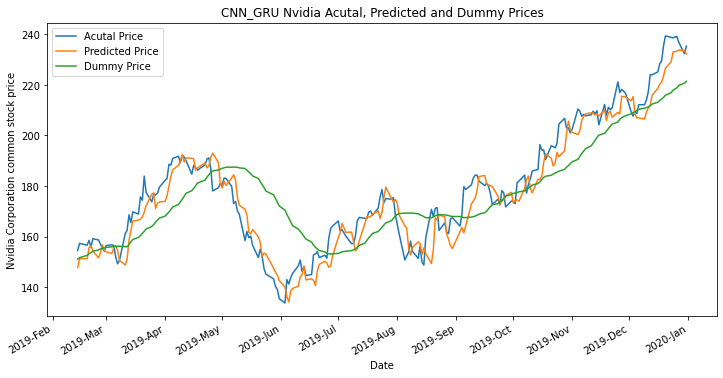

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

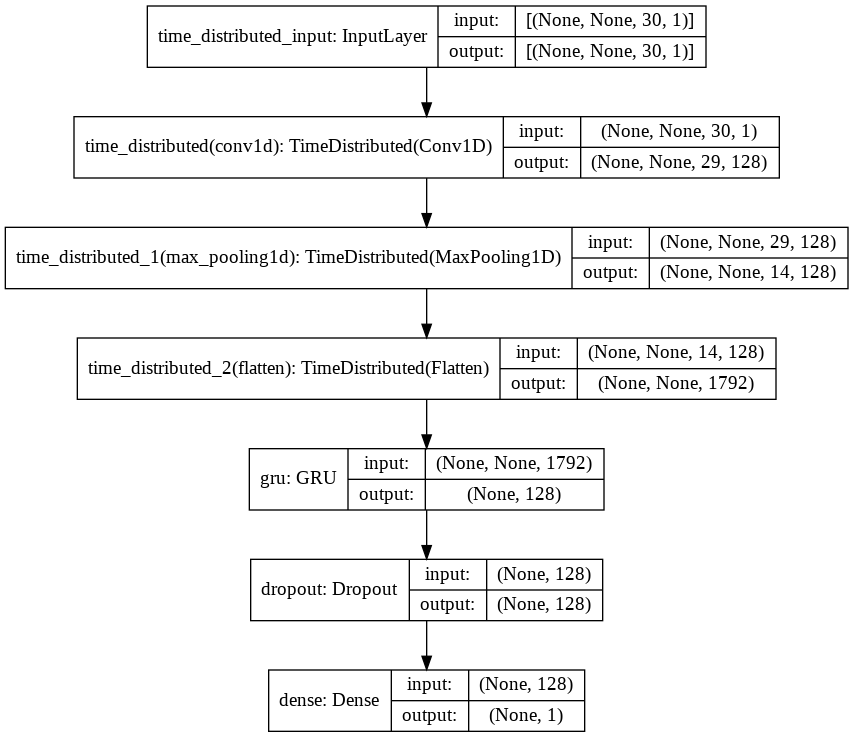

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.003598620286337445
RMSE:  0.05998850128430819
MAE:  0.04767772987057164
Dummy MSE:  0.01623808785220405
Dummy RMSE:  0.12742875598625314
Dummy MAE:  0.10320580289003882


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Nvidia/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Nvidia/assets
